In [ ]:
# Le voyageur de commerce

Ce projet est inspiré du Chapitre 4 du livre “The Cross-Entropy Method” de
Rubinstein et Kroese.

Le problème du voyageur de commerce (en anglais, TSP, travelling salesman
problem) revient à minimiser le trajet effectué entre M villes, sous la contrainte
de passer par chaque ville exactement une fois. Soit D la matrice telle que Dij
est la distance entre la ville i et la ville j; noter que Dii = 0 et D est symétrique.

1) Rappeler (ou retrouver!) la méthode permettant de simuler efficacement
N vecteurs selon la loi Multinomiale définie par le vecteur de probabilité
p = (p1, . . . , pM). La mettre en œuvre.

In [1]:
import matplotlib.pyplot as plt
import seaborn
%pylab inline
%load_ext line_profiler
from scipy.stats import expon, uniform

Populating the interactive namespace from numpy and matplotlib


(array([ 1006.,  1033.,  1010.,   978.,   960.,   964.,   999.,   980.,
         1050.,  1020.]),
 array([  1.06924608e-04,   1.00095826e-01,   2.00084728e-01,
          3.00073629e-01,   4.00062531e-01,   5.00051433e-01,
          6.00040334e-01,   7.00029236e-01,   8.00018137e-01,
          9.00007039e-01,   9.99995940e-01]),
 <a list of 10 Patch objects>)

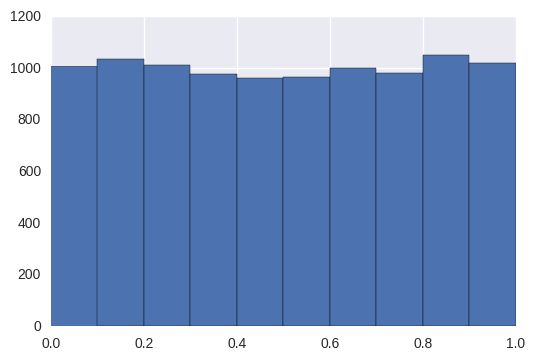

In [2]:
def sorted_uniforms(N):
    """
    Returns N sorted uniforms
    """
    E = expon.rvs(size=N+1)
    V = [sum(E[:i+1]) for i in range(N+1)]
    return V[:-1]/V[-1]

plt.hist(sorted_uniforms(10000))

In [3]:
def multinomial_old(P, N):
    """
    Returns a vector of N multinomials
    """
    su = sorted_uniforms(N)
    j = 0
    s = P[0]
    A = [0]
    for n in range(N):
        while su[n] > s:
            j += 1
            A += [0]
            s += P[j]
        A[j] += 1
        
    return A

In [4]:
def alternative_multinomial(P,N):
    """ Returs a vector of N multinomial using binomial distribution"""
    number_simulated = 0
    n_coeffs = len(P)
    multinomials = [0 for i in range(n_coeffs)]
    i = 0
    N_ = N
    while N_ > 0 and i < n_coeffs :
        N_ -= number_simulated
        binomial = uniform.rvs(size = N_)
        n_p = np.count_nonzero(binomial < P[i])
        multinomials[i] = np.count_nonzero(binomial < P[i])
        i+=1
    return multinomials

In [5]:
P = [1/4, 1/4, 1/4, 1/8, 1/8]
print(multinomial_old(P, 1000))
print(alternative_multinomial(P, 1000))

[267, 239, 245, 117, 132]
[233, 249, 238, 99, 137]


In [8]:
n = 10000
print("multinomial old :")
%timeit multinomial_old(P, n)
print("alternative multinomial:")
%timeit alternative_multinomial(P, n)
print("numpy multinomial:")
%timeit np.random.multinomial(n, P, size=1)

multinomial old :
10 loops, best of 3: 50.2 ms per loop
alternative multinomial:
1000 loops, best of 3: 888 µs per loop
numpy multinomial:
The slowest run took 15.35 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.22 µs per loop


2) Utiliser l’algorithme CE vu en cours pour résoudre le problème TSP. Pour
ce faire, proposer une famille paramétrique de lois pour la simulation de
trajets. Programmer cet algorithme, et le tester sur quelques exemples.

In [9]:
# Random distance matrix
number_of_cities = 100
D = np.reshape(np.random.exponential(number_of_cities, number_of_cities**2), (number_of_cities,number_of_cities))
for i in range(number_of_cities):
    D[i,i] = 0
    for j in range(number_of_cities):
        D[i,j] = D[j, i]

# Random transition matrix
from sklearn.preprocessing import normalize
P = np.reshape(np.random.rand(number_of_cities**2), (number_of_cities,number_of_cities))
for i in range(number_of_cities): 
    P[i,i] = 0
P = P/P.sum(axis=1)[:,None]
P

array([[ 0.        ,  0.0079897 ,  0.00037264, ...,  0.00623487,
         0.01161193,  0.00538612],
       [ 0.01612017,  0.        ,  0.01313322, ...,  0.0087432 ,
         0.00952881,  0.00930113],
       [ 0.00360983,  0.0047165 ,  0.        , ...,  0.01765192,
         0.01466807,  0.019452  ],
       ..., 
       [ 0.0196407 ,  0.00180745,  0.0127738 , ...,  0.        ,
         0.01429633,  0.01298204],
       [ 0.01313004,  0.01631336,  0.01282025, ...,  0.0193415 ,
         0.        ,  0.01815233],
       [ 0.00424138,  0.00815244,  0.01936208, ...,  0.01771325,
         0.01334125,  0.        ]])

In [10]:
def trajectory(P):
    """
    
    """
    P_ = P.copy()
    X = np.zeros(len(P), np.int8)
    for i in range(len(P)-1):
        P_[:,X[i]] = 0
        P_ = P_/P_.sum(axis=1)[:,None]
        X[i+1] = multinomial_old(P_[X[i],:], 1)[0]
    return X

X = trajectory(P)

In [9]:
%lprun -f trajectory trajectory(P)

In [11]:
def multi_trajectories_old(P, N):
    return [trajectory(P) for i in range(N)]

In [125]:
%lprun -f multi_trajectories_old multi_trajectories_old(P, 3)

In [12]:
def multi_trajectories(P, N):
    d = {(0):N}
    for i in range(len(P)-1):
        d = one_step(d, P)
    return d

In [35]:
%lprun -f one_step multi_trajectories(P, 100)

In [14]:
def one_step(d, P):
    
    # d represents a partial trajectory
    new_dict = {}
    
    for traj in d.keys():
        n = d[traj]
        if traj != 0:
            traj = list(traj)
        else:
            traj = [0]
        
        P1 = P.copy()
        alpha = P1[traj[-1], :]
        for previous_node in traj[:-1]:
            alpha[previous_node] = 0
        alpha = alpha / sum(alpha)
        # new  = multinomial(alpha, n)
        new = np.random.multinomial(n, alpha, size=1).tolist()[0]
        new_dict.update({ tuple(traj + [j]) : new[j] for j in range(1, len(new)) if new[j] != 0})
    return new_dict

In [19]:
def S(X, D):
    """
    Input: 
    X 1D-array representing a path on a graph
    D 2D-array distance matrice for the graph
    
    Output:
    The length of the path X (starting from X[0] and ending on X[0])
    
    """
    return sum([D[X[i], X[(i+1)%len(X)]] for i in range(len(X)-1)])

In [20]:
def init_P(size):
    """
    Returns a stochastic matrix of dim size*size with zeros on the diagonal and 1/(size-1) elsewhere 
    """
    P = (np.ones((size, size)) - np.identity((size)))/(size-1)
    return P

init_P(3)

array([[ 0. ,  0.5,  0.5],
       [ 0.5,  0. ,  0.5],
       [ 0.5,  0.5,  0. ]])

In [38]:
def cross_entropy(C, n, rho=1, alpha=0.99):

    degree = len(C)
    
    P = init_P(degree)

    length = [0,1]
    
    while max(length) > min(length):
        trajectories = multi_trajectories(P, n)
        
        trajectories = [np.array(traj) for traj in trajectories.keys()]
                
        length = [S(trajectory, C) for trajectory in trajectories]

        gamma = np.percentile(length, rho, interpolation='lower')

        trajectories_sample = [traj for traj in trajectories if S(traj, C) <= gamma]
        
        P_ = np.zeros(P.shape)
        
        for i in range(degree):
            for traj in trajectories_sample:
                P_[traj[i], traj[(i+1)%degree]] += 1/len(trajectories_sample)
        P = alpha * P_ + (1-alpha)* P            
    
    return P, gamma, trajectories_sample[0]

In [31]:
def cross_entropy_old(C, n, rho=1, alpha=0.99):
    
    degree = len(C)
    
    P = init_P(degree)

    length = [0,1]
    while max(length) > min(length):
        trajectories = multi_trajectories_old(P, n)
                        
        length = [S(trajectory, C) for trajectory in trajectories]

        gamma = np.percentile(length, rho, interpolation='lower')

        trajectories_sample = [traj for traj in trajectories if S(traj, C) <= gamma]

        couples = [[(traj[i], traj[(i+1)%degree]) for i in range(degree)] for traj in trajectories_sample]
        
        P_ = P.copy()
        
        for i in range(degree):
            for j in range(degree):
                P_[i,j] = sum([1 for couple in couples if (i,j) in couple])/len(trajectories_sample)

        P = alpha * P_ + (1-alpha)* P        
    
    return P, gamma, trajectories_sample[0]

In [40]:
%lprun -f cross_entropy cross_entropy(D, 100)

In [41]:
P, gamma, traj =  cross_entropy(D, 100)

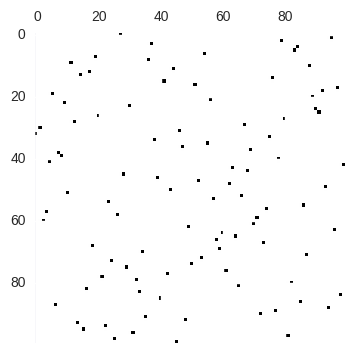

In [42]:
plt.matshow(P,interpolation='none')

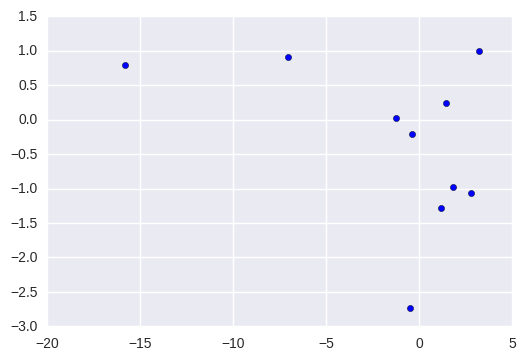

In [56]:
number_of_cities = 10
X = np.array([(np.random.standard_cauchy(2)) for i in range(number_of_cities)])
plt.scatter(X[:,0], X[:,1])

In [57]:
D = np.empty((number_of_cities,number_of_cities))
for i in range(number_of_cities):
    D[i,i] = 0
    for j in range(number_of_cities):
        D[i,j] = np.linalg.norm(X[i]-X[j])
        D[j,i] = D[i,j]

In [60]:
P, gamma, best_traj = cross_entropy(D, 100)

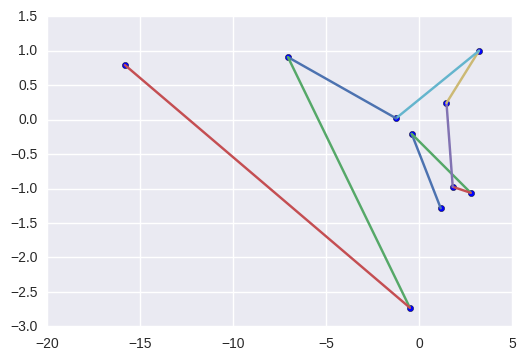

In [61]:
for i in range(len(best_traj)-1):
    plt.plot((X[best_traj[i]][0], X[best_traj[i+1]][0]), (X[best_traj[i]][1], X[best_traj[i+1]][1]))
plt.scatter(X[:,0], X[:,1])

3) Concernant l’estimation bayésienne de vecteurs de probabilité d’une loi
multinomiale, retrouver le fait que la famille des lois de Dirichlet est
conjuguée pour ce modèle. Expliquer comment en pratique vous pouvez
utiliser cette propriété pour améliorer votre algorithme.

If $p = (p_1,...,p_k) \sim Dirichlet_k(\alpha_1, ..., \alpha_k)$, the density of $p$ is given by :
$$ \pi(p_1,...,p_k ; \alpha_1, ..., \alpha_k) = \dfrac{1}{B(\alpha)} \Pi_{i=1}^k p_i^{\alpha_i - 1} $$ 
for all $p_1,...,p_k >0$ such that $p_k = 1 - \sum_{j=1}^{k-1} p_j$.

If $x = (x_1,...,x_k) \sim Multinomial(p_1,...,p_k)$, the likelihood of $x$ is given by :

$$ L(x_1,...,x_k ; p_1,...,p_k) = \dfrac{ (\sum_i x_i)! }{x_1!...x_k!} \Pi_{i=1}^k p_i^{x_i} $$

We deduce :

$$ \pi(p_1,...,p_k ; \alpha_1, ..., \alpha_k, x_1,...,x_k) \propto \Pi_{i=1}^k p_i^{\alpha_i + x_i - 1} $$ 

Hence, by identification, $p|x \sim Dirichlet_k(\alpha_1 + x_1, ..., \alpha_k + x_k)$ so the Dirichlet distribution family is conjugate for this model.

In [47]:
def bayesian_multi_trajectories(alpha, N):
    l = []
    P = np.empty((len(alpha), len(alpha)))
    for j in range(N):
        for i in range(len(alpha)):
            P[i,:] = numpy.random.dirichlet(alpha[i,:])
            l += [trajectory(P)]
    return l

In [48]:
def bayesian_cross_entropy(C, n, rho=5):
    
    degree = len(C)
                
    alpha = np.ones((degree, degree))
    
    length = [0,1]
    
    while max(length) > min(length):
        
        trajectories = bayesian_multi_trajectories(alpha, n)
        
        
        
        length = [S(trajectory, C) for trajectory in trajectories]

        gamma = np.percentile(length, rho, interpolation='lower')

        trajectories_sample = [traj for traj in trajectories if S(traj, C) <= gamma]
                
        couples = [[(traj[i], traj[(i+1)%degree]) for i in range(degree)] for traj in trajectories_sample]
        
        print(max(length), min(length))
        
        for i in range(degree):
            for j in range(degree):
                alpha[i,j] += sum([1 for couple in couples if (i,j) in couple])            
    
    return alpha, gamma, trajectories_sample[0]

In [49]:
alpha, gamma, best_traj = bayesian_cross_entropy(D, 10)

KeyboardInterrupt: 

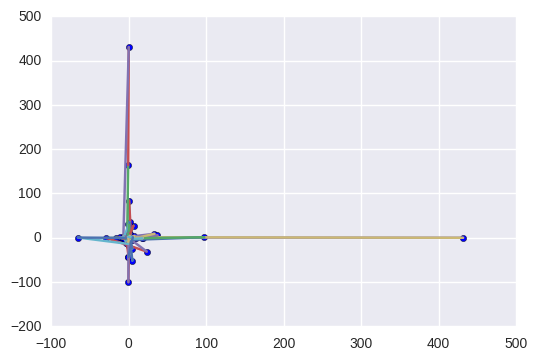

In [50]:
for i in range(len(best_traj)-1):
    plt.plot((X[best_traj[i]][0], X[best_traj[i+1]][0]), (X[best_traj[i]][1], X[best_traj[i+1]][1]))
plt.scatter(X[:,0], X[:,1])

4) Bonus: en fonction du temps disponible, vous pouvez tester votre algorithme
sur de “gros” problèmes (par ex. trajet optimal du tour de France
en se basant sur la liste des villes de l’année dernière), ou comparer à
d’autres algorithmes que vous trouverez dans la littérature.

Faire tourner sur des villes random en France

In [82]:
import pandas as pd
# https://opendata.paris.fr/explore/dataset/arbresremarquablesparis2011/table/
df = pd.read_csv('arbresremarquablesparis2011.csv', sep=';')
# arbutus ou sequoia
df = df[df['GENRE']=='Arbutus']

In [83]:
geo_points = df['Geo point'].tolist()
nb_trees = len(geo_points)
geo_points = [(float(geo_point_str.split(',')[0]), float(geo_point_str.split(',')[1])) for geo_point_str in geo_points]

In [84]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [85]:
D_trees = numpy.empty((nb_trees,nb_trees))
for i in range(nb_trees):
    D_trees[i,i] = 0
    for j in range(nb_trees):
        lon1, lat1 = geo_points[i][0], geo_points[i][1]
        lon2, lat2 = geo_points[j][0], geo_points[j][1]
        D_trees[i,j] = haversine(lon1, lat1, lon2, lat2)
        D_trees[j,i] = D_trees[i,j]

In [97]:
alpha, gamma, best_traj = cross_entropy(D_trees, 500)

In [98]:
polyline_best_traj = [geo_points[point] for point in best_traj] + [geo_points[0]]

In [99]:
map_osm = folium.Map(location=[48.85, 2.34])
for i in range(len(geo_points)-1):
    folium.Marker(geo_points[i], popup='Sequoia').add_to(map_osm)

folium.PolyLine(polyline_best_traj, color="red", weight=2.5, opacity=1).add_to(map_osm)
from IPython.display import HTML
map_osm